In [1]:
# GRU modelis Bitcoin kainai prognozuoti
#
# Šiame notebook implementuosime GRU (Gated Recurrent Unit) modelį, kuris yra alternatyva LSTM ir taip pat tinka laiko eilučių duomenims.

In [2]:
# Reikalingų bibliotekų importavimas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import requests
from datetime import datetime, timedelta

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# Duomenų gavimas iš Binance API
BINANCE_API_URL = "https://api.binance.com/api/v3/klines"

def get_historical_klines(symbol="BTCUSDT", interval="15m", start_time=None, end_time=None):
    if end_time is None:
        end_time = datetime.now()
    if start_time is None:
        start_time = end_time - timedelta(days=1825)
    start_ts = int(start_time.timestamp() * 1000)
    end_ts = int(end_time.timestamp() * 1000)
    all_klines = []
    current_start = start_ts
    while current_start < end_ts:
        params = {
            'symbol': symbol,
            'interval': interval,
            'startTime': current_start,
            'endTime': end_ts,
            'limit': 1000
        }
        try:
            response = requests.get(BINANCE_API_URL, params=params)
            response.raise_for_status()
            klines = response.json()
            if not klines:
                break
            all_klines.extend(klines)
            current_start = int(klines[-1][0]) + 1
            time.sleep(0.5)
        except Exception as e:
            print(f"Klaida gaunant duomenis: {str(e)}")
            time.sleep(2)
    if all_klines:
        columns = ['time', 'open', 'high', 'low', 'close', 'volume', 
                   'close_time', 'quote_asset_volume', 'number_of_trades',
                   'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
        df = pd.DataFrame(all_klines, columns=columns)
        df['time'] = pd.to_datetime(df['time'], unit='ms')
        numeric_columns = ['open', 'high', 'low', 'close', 'volume']
        df[numeric_columns] = df[numeric_columns].astype(float)
        print(f"Sėkmingai gauta {len(df)} įrašų")
        return df
    return None

end_time = datetime.now()
start_time = end_time - timedelta(days=1825)
print(f"Gaunami duomenys nuo {start_time} iki {end_time}...")
df = get_historical_klines(symbol="BTCUSDT", interval="15m", start_time=start_time, end_time=end_time)
if df is not None:
    display(df.head())
else:
    raise Exception("Nepavyko gauti duomenų, tęsti negalima.")

Gaunami duomenys nuo 2020-05-24 03:09:06.961029 iki 2025-05-23 03:09:06.961029...
Sėkmingai gauta 175092 įrašų


,time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
0,2020-05-24 00:15:00,9159.78,9182.28,9149.86,9174.77,473.021813,1590280199999,4336500.79900815,6057,180.86044300,1657914.31919030,0
1,2020-05-24 00:30:00,9174.77,9189.67,9170.00,9188.25,404.924533,1590281099999,3717366.44884640,5848,167.46637900,1537498.14131201,0
2,2020-05-24 00:45:00,9187.64,9212.00,9186.31,9196.38,458.199259,1590281999999,4215553.77719967,6889,189.94266400,1747587.16810438,0
3,2020-05-24 01:00:00,9196.38,9208.82,9185.93,9190.30,201.842188,1590282899999,1856587.14571205,3735,96.89518800,891225.13274693,0
4,2020-05-24 01:15:00,9190.31,9212.23,9188.99,9206.14,204.320227,1590283799999,1879683.45940717,3829,97.19618400,894216.24637652,0


In [4]:
# Duomenų paruošimas
df = df.sort_values('time')
print(f"Duomenų intervalas: nuo {df['time'].min()} iki {df['time'].max()}")
print(f"Įrašų skaičius: {len(df)}")
if df.isnull().sum().sum() > 0:
    print("Užpildome trūkstamas reikšmes...")
    df = df.fillna(method='ffill')

Duomenų intervalas: nuo 2020-05-24 00:15:00 iki 2025-05-23 00:00:00
Įrašų skaičius: 175092


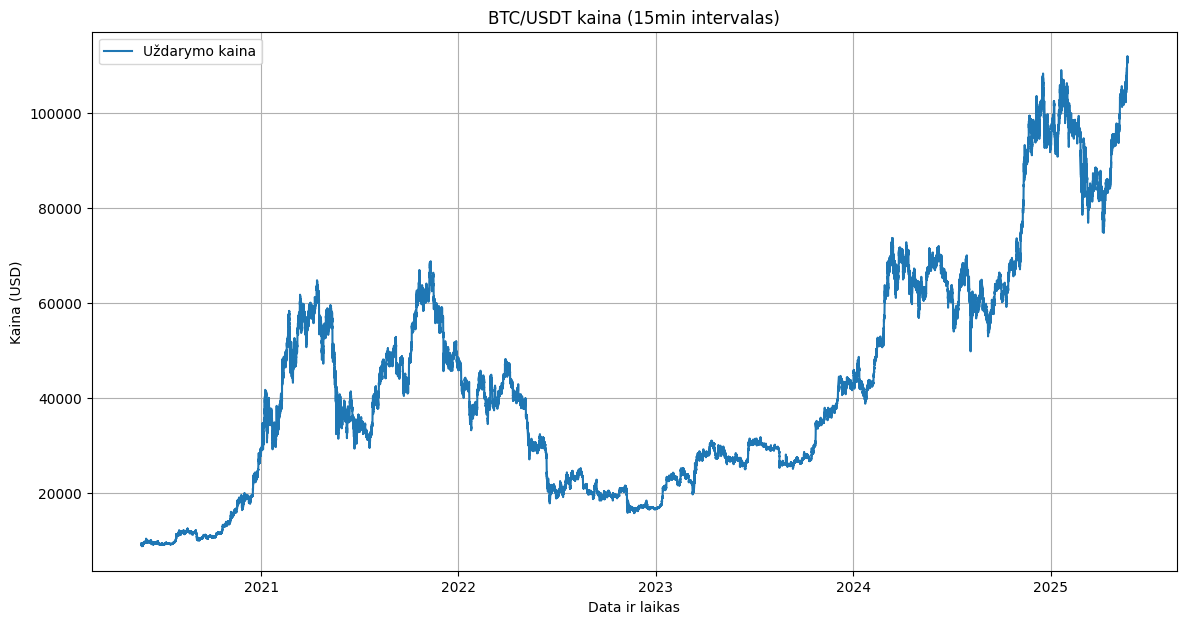

In [5]:
# Vizualizacija
plt.figure(figsize=(14, 7))
plt.plot(df['time'], df['close'], label='Uždarymo kaina')
plt.title('BTC/USDT kaina (15min intervalas)')
plt.xlabel('Data ir laikas')
plt.ylabel('Kaina (USD)')
plt.grid(True)
plt.legend()
plt.show()

In [6]:
# Normalizavimas
columns_to_normalize = ['open', 'high', 'low', 'close', 'volume']
scaler = MinMaxScaler()
df_original = df.copy()
df_normalized = df.copy()
df_normalized[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])
df_normalized.head()

,time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
0,2020-05-24 00:15:00,0.004565,0.004294,0.004922,0.004707,0.011717,1590280199999,4336500.79900815,6057,180.86044300,1657914.31919030,0
1,2020-05-24 00:30:00,0.004711,0.004365,0.005117,0.004837,0.010030,1590281099999,3717366.44884640,5848,167.46637900,1537498.14131201,0
2,2020-05-24 00:45:00,0.004835,0.004582,0.005276,0.004916,0.011350,1590281999999,4215553.77719967,6889,189.94266400,1747587.16810438,0
3,2020-05-24 01:00:00,0.004920,0.004551,0.005272,0.004857,0.005000,1590282899999,1856587.14571205,3735,96.89518800,891225.13274693,0
4,2020-05-24 01:15:00,0.004861,0.004584,0.005302,0.005011,0.005061,1590283799999,1879683.45940717,3829,97.19618400,894216.24637652,0


In [7]:
# Sliding window sekų kūrimas
def create_sequences(data, target_column, sequence_length):
    X, y = [], []
    feature_columns = ['open', 'high', 'low', 'close', 'volume']
    data_array = data[feature_columns].values
    target_idx = feature_columns.index(target_column)
    for i in range(len(data) - sequence_length):
        X.append(data_array[i:i + sequence_length])
        y.append(data_array[i + sequence_length, target_idx])
    return np.array(X), np.array(y)

sequence_length = 10
target_column = 'close'
feature_columns = ['open', 'high', 'low', 'close', 'volume']
X, y = create_sequences(df_normalized, target_column, sequence_length)
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (175082, 10, 5), y shape: (175082,)


In [8]:
# Duomenų padalijimas į mokymo ir testavimo rinkinius
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

X_train shape: (140065, 10, 5), X_test shape: (35017, 10, 5)
y_train shape: (140065,), y_test shape: (35017,)


In [9]:
# GRU modelio kūrimas
def create_gru_model(input_shape):
    model = Sequential([
        GRU(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        GRU(32, return_sequences=False),
        Dropout(0.2),
        Dense(16),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

input_shape = (X_train.shape[1], X_train.shape[2])
gru_model = create_gru_model(input_shape)
gru_model.summary()

d:\CA_BTC\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 10, 64)         │        13,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,585 (92.13 KB)

 Trainable params: 23,585 (92.13 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Apibrėžiame callback funkcijas ir apmokome modelį
os.makedirs('../../models', exist_ok=True)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint(
        filepath='../../models/gru_model.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

batch_size = 32
epochs = 50

history = gru_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
4378/4378 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013

4378/4378 ━━━━━━━━━━━━━━━━━━━━ 65s 13ms/step - loss: 0.0013 - val_loss: 3.6922e-04
Epoch 2/50
4378/4378 ━━━━━━━━━━━━━━━━━━━━ 55s 12ms/step - loss: 2.5112e-04 - val_loss: 0.0013
Epoch 3/50
4378/4378 ━━━━━━━━━━━━━━━━━━━━ 54s 12ms/step - loss: 2.5053e-04 - val_loss: 0.0014
Epoch 4/50
4378/4378 ━━━━━━━━━━━━━━━━━━━━ 56s 13ms/step - loss: 2.4169e-04 - val_loss: 4.1541e-04
Epoch 5/50
4378/4378 ━━━━━━━━━━━━━━━━━━━━ 62s 14ms/step - loss: 2.3479e-04 - val_loss: 5.6359e-04
Epoch 6/50
4375/4378 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.3504e-04

4378/4378 ━━━━━━━━━━━━━━━━━━━━ 58s 13ms/step - loss: 2.3504e-04 - val_loss: 1.5679e-04
Epoch 7/50
4378/4378 ━━━━━━━━━━━━━━━━━━━━ 53s 12ms/step - loss: 2.2681e-04 - val_loss: 0.0016
Epoch 8/50
4378/4378 ━━━━━━━━━━━━━━━━━━━━ 54s 12ms/step - loss: 2.2671e-04 - val_loss: 0.0030
Epoch 9/50
4378/4378 ━━━━━━━━━━━━━━━━━━━━ 55s 13ms/step - loss: 2.2727e-04 - val_loss: 0.0063
Epoch 10/50
4378/4378 ━━━━━━━━━━━━━━━━━━━━ 56s 13ms/step - loss: 2.2178e-04 - val_loss: 0.0173
Epoch 11/50
4378/4378 ━━━━━━━━━━━━━━━━━━━━ 56s 13ms/step - loss: 2.2104e-04 - val_loss: 0.0299
Epoch 12/50
4378/4378 ━━━━━━━━━━━━━━━━━━━━ 54s 12ms/step - loss: 2.1885e-04 - val_loss: 0.0364
Epoch 13/50
4378/4378 ━━━━━━━━━━━━━━━━━━━━ 54s 12ms/step - loss: 2.1529e-04 - val_loss: 0.0399
Epoch 14/50
4378/4378 ━━━━━━━━━━━━━━━━━━━━ 55s 13ms/step - loss: 2.1825e-04 - val_loss: 0.0404
Epoch 15/50
4378/4378 ━━━━━━━━━━━━━━━━━━━━ 55s 13ms/step - loss: 2.1660e-04 - val_loss: 0.0409
Epoch 16/50
4378/4378 ━━━━━━━━━━━━━━━━━━━━ 56s 13ms/step - lo

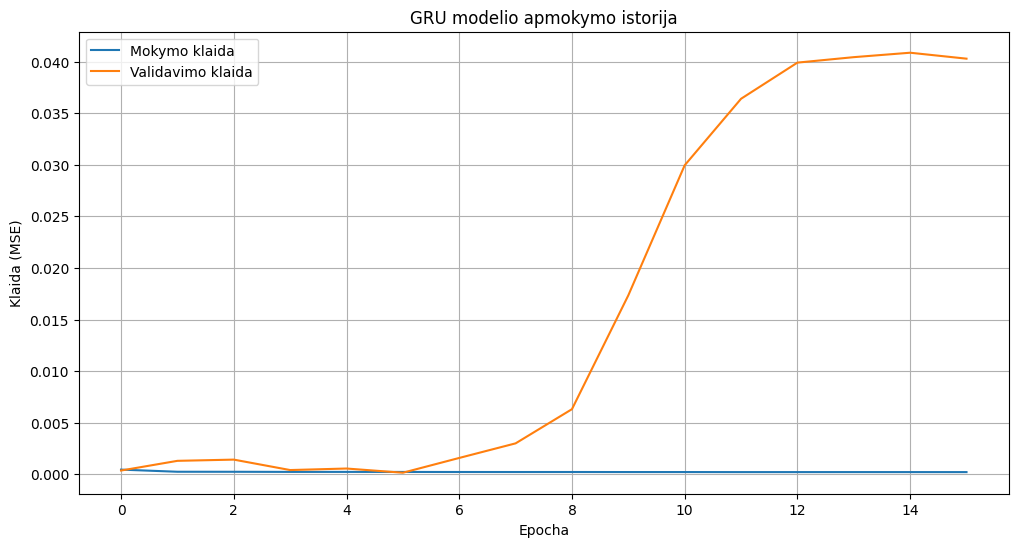

In [11]:
# Vizualizuojame apmokymo istoriją
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Mokymo klaida')
plt.plot(history.history['val_loss'], label='Validavimo klaida')
plt.title('GRU modelio apmokymo istorija')
plt.xlabel('Epocha')
plt.ylabel('Klaida (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# Prognozuojame su testavimo duomenimis
y_pred = gru_model.predict(X_test)

def inverse_transform_predictions(predictions, scaler, target_idx=3):
    dummy = np.zeros((len(predictions), len(feature_columns)))
    dummy[:, target_idx] = predictions.flatten()
    inverse_predicted = scaler.inverse_transform(dummy)
    return inverse_predicted[:, target_idx]

target_idx = feature_columns.index(target_column)
y_pred_original = inverse_transform_predictions(y_pred, scaler, target_idx)
y_test_original = inverse_transform_predictions(y_test.reshape(-1, 1), scaler, target_idx)
print(f"y_pred_original shape: {y_pred_original.shape}")
print(f"y_test_original shape: {y_test_original.shape}")

1095/1095 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
y_pred_original shape: (35017,)
y_test_original shape: (35017,)


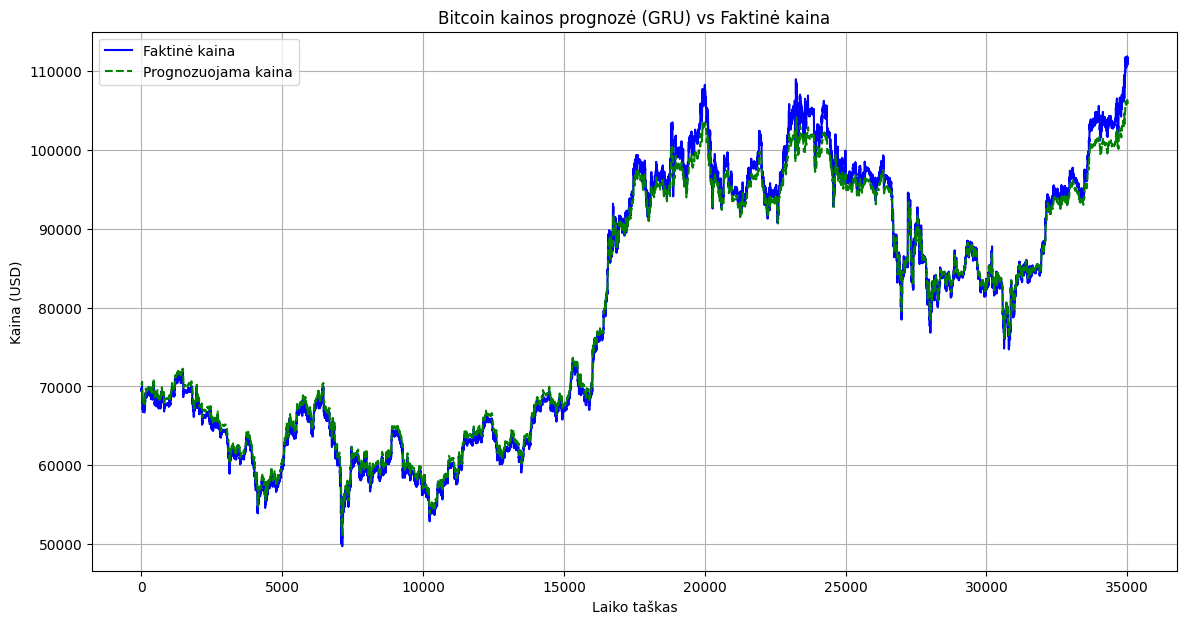

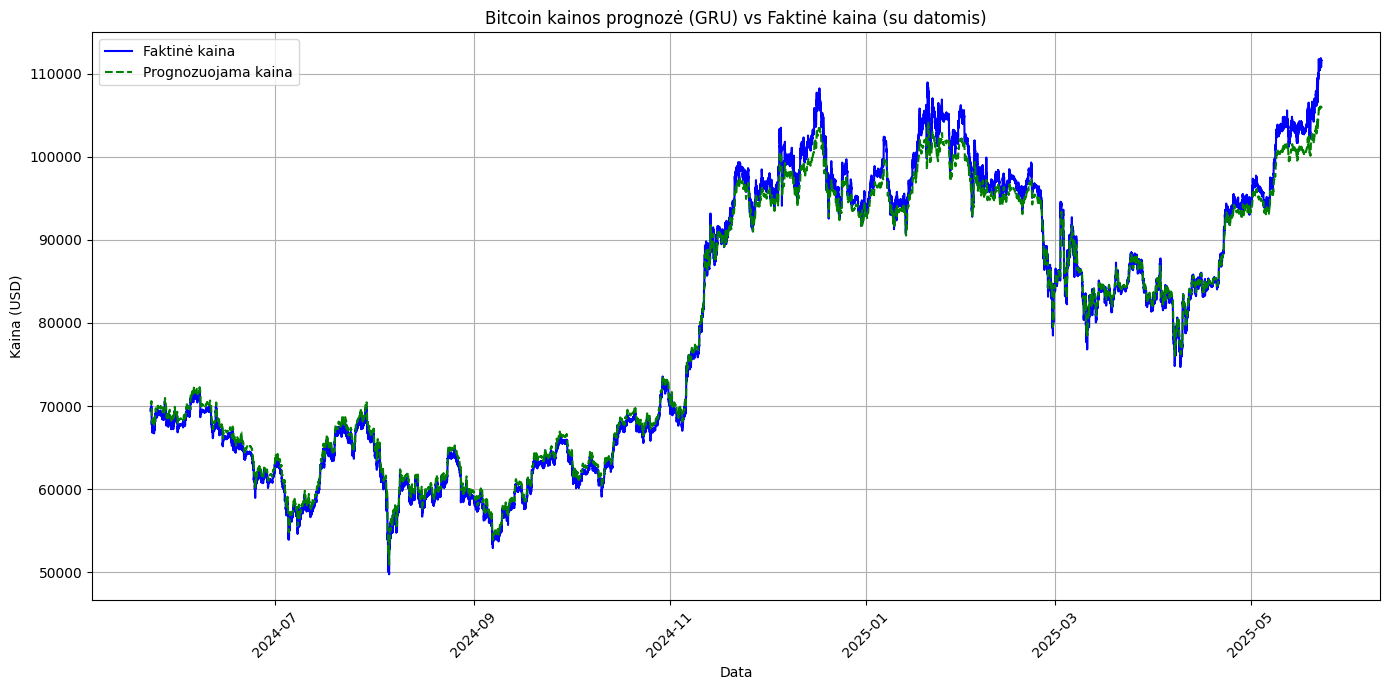

In [13]:
# Vizualizuojame prognozes
plt.figure(figsize=(14, 7))
plt.plot(y_test_original, label='Faktinė kaina', color='blue')
plt.plot(y_pred_original, label='Prognozuojama kaina', color='green', linestyle='--')
plt.title('Bitcoin kainos prognozė (GRU) vs Faktinė kaina')
plt.xlabel('Laiko taškas')
plt.ylabel('Kaina (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Papildomai su datomis
test_dates = df_original['time'].iloc[-len(y_test):].reset_index(drop=True)
plt.figure(figsize=(14, 7))
plt.plot(test_dates, y_test_original, label='Faktinė kaina', color='blue')
plt.plot(test_dates, y_pred_original, label='Prognozuojama kaina', color='green', linestyle='--')
plt.title('Bitcoin kainos prognozė (GRU) vs Faktinė kaina (su datomis)')
plt.xlabel('Data')
plt.ylabel('Kaina (USD)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
# Apskaičiuojame prognozavimo metrikas
mse = mean_squared_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)
mape = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Squared Error (MSE): 1670178.91
Root Mean Squared Error (RMSE): 1292.35
Mean Absolute Error (MAE): 1003.58
R² Score: 0.9938
Mean Absolute Percentage Error (MAPE): 1.20%


In [15]:
# Išsaugome modelį ir rezultatus
import json

model_info = {
    'model_type': 'GRU',
    'input_shape': input_shape,
    'sequence_length': sequence_length,
    'target_column': target_column,
    'metrics': {
        'mse': float(mse),
        'rmse': float(rmse),
        'mae': float(mae),
        'r2': float(r2),
        'mape': float(mape)
    }
}

model_info_path = '../../models/gru_model_info.json'
with open(model_info_path, 'w') as f:
    json.dump(model_info, f, indent=4)

print(f"Modelio informacija išsaugota: {model_info_path}")
print("GRU modelio apmokymas ir įvertinimas baigtas!")

Modelio informacija išsaugota: ../../models/gru_model_info.json
GRU modelio apmokymas ir įvertinimas baigtas!


In [16]:
# GRU modelio eksportavimas
import os
target_dir = 'd:/CA_BTC/app/models/gru'
os.makedirs(target_dir, exist_ok=True)
save_model(gru_model, os.path.join(target_dir, '1.h5'))
joblib.dump(gru_scaler, os.path.join(target_dir, '1_scaler.pkl'))

NameError: name 'save_model' is not defined